<a href="https://colab.research.google.com/github/KhuyenLE-maths/An_overview_of_VGG_and_NiN_models/blob/main/An_overview_of_VGG16_and_NiN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This post aims to introduce briefly two classic convolutional neural networks, VGG16 and NiN (a.k.a Network in Network). We are going to discover their architectures as well as their implementations on the Keras platform. You can refer to my previous blogs for some related topics: [Convolutional neural networks](https://lekhuyen.medium.com/convolutional-neural-networks-3f00c165c9d9), [LeNet](https://lekhuyen.medium.com/lenet-and-mnist-handwritten-digit-classification-354f5646c590), and [Alexnet](https://lekhuyen.medium.com/alexnet-and-image-classification-8cd8511548b4) models.

# I. VGG model

## 1. Introduction

VGG is a deep convolutional neural network that was proposed by Karen Simonyan and Andrew Zisserman [1]. VGG is an acronym for their group name, [Visual Geometry Group](https://www.robots.ox.ac.uk/~vgg/), from the Oxford University. This model secured 2nd place in the ILSVRC-2014 competition where 92.7% classification performance was achieved. The VGG model investigates the depth of layers with a very small convolutional filter size (3 × 3) to deal with large-scale images. The authors released a series of VGG models with different layer lengths, from 11 to 19, which is presented in the following table.

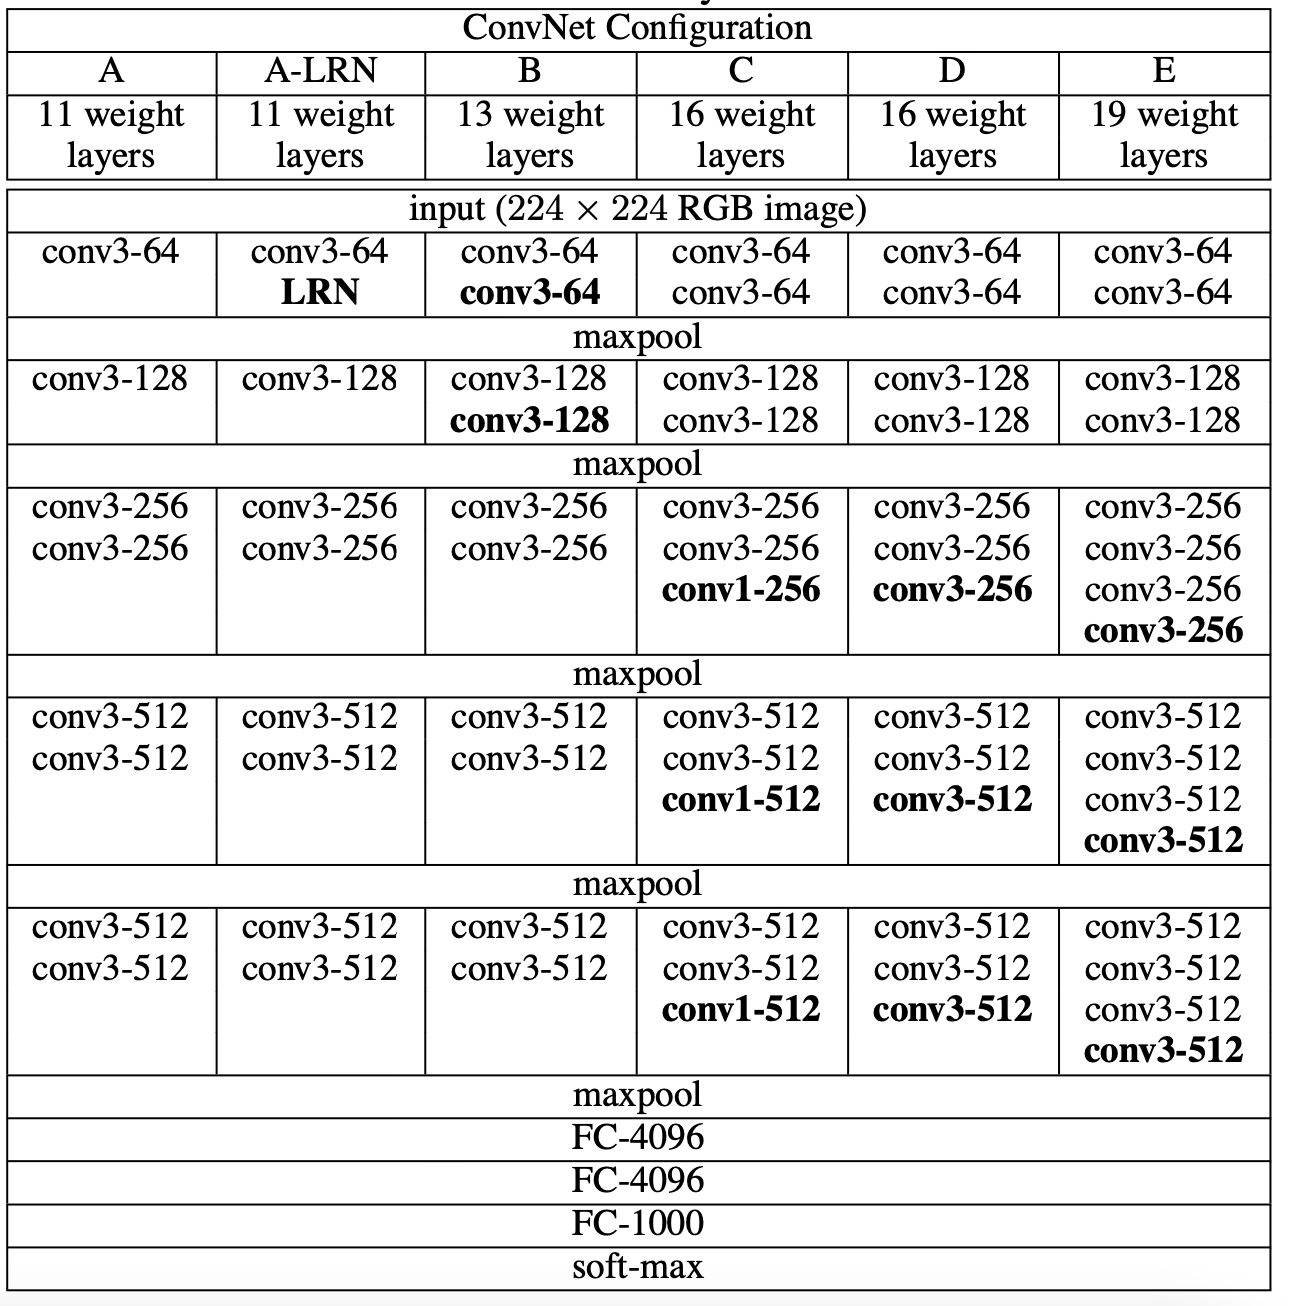

In summary:
- All configurations of VGG have block structures.
- Each VGG block consists of a sequence of convolutional layers which are followed by a max-pooling layer. The same kernel size (3 × 3) is applied over all convolutional layers. Besides, the authors used a padding size of 1 to keep the size of the output after each convolutional layer. A max-pooling of size 2 × 2 with strides of 2 is also applied to halve the resolution after each block
- Each VGG model has two fully connected hidden layers and one fully connected output layer.

In this post, we only focus on the deployment of the VGG16, its architecture as well as its implementation on Keras. Other configurations are constructed similarly.

The structure of VGG16 is described by the following figure:

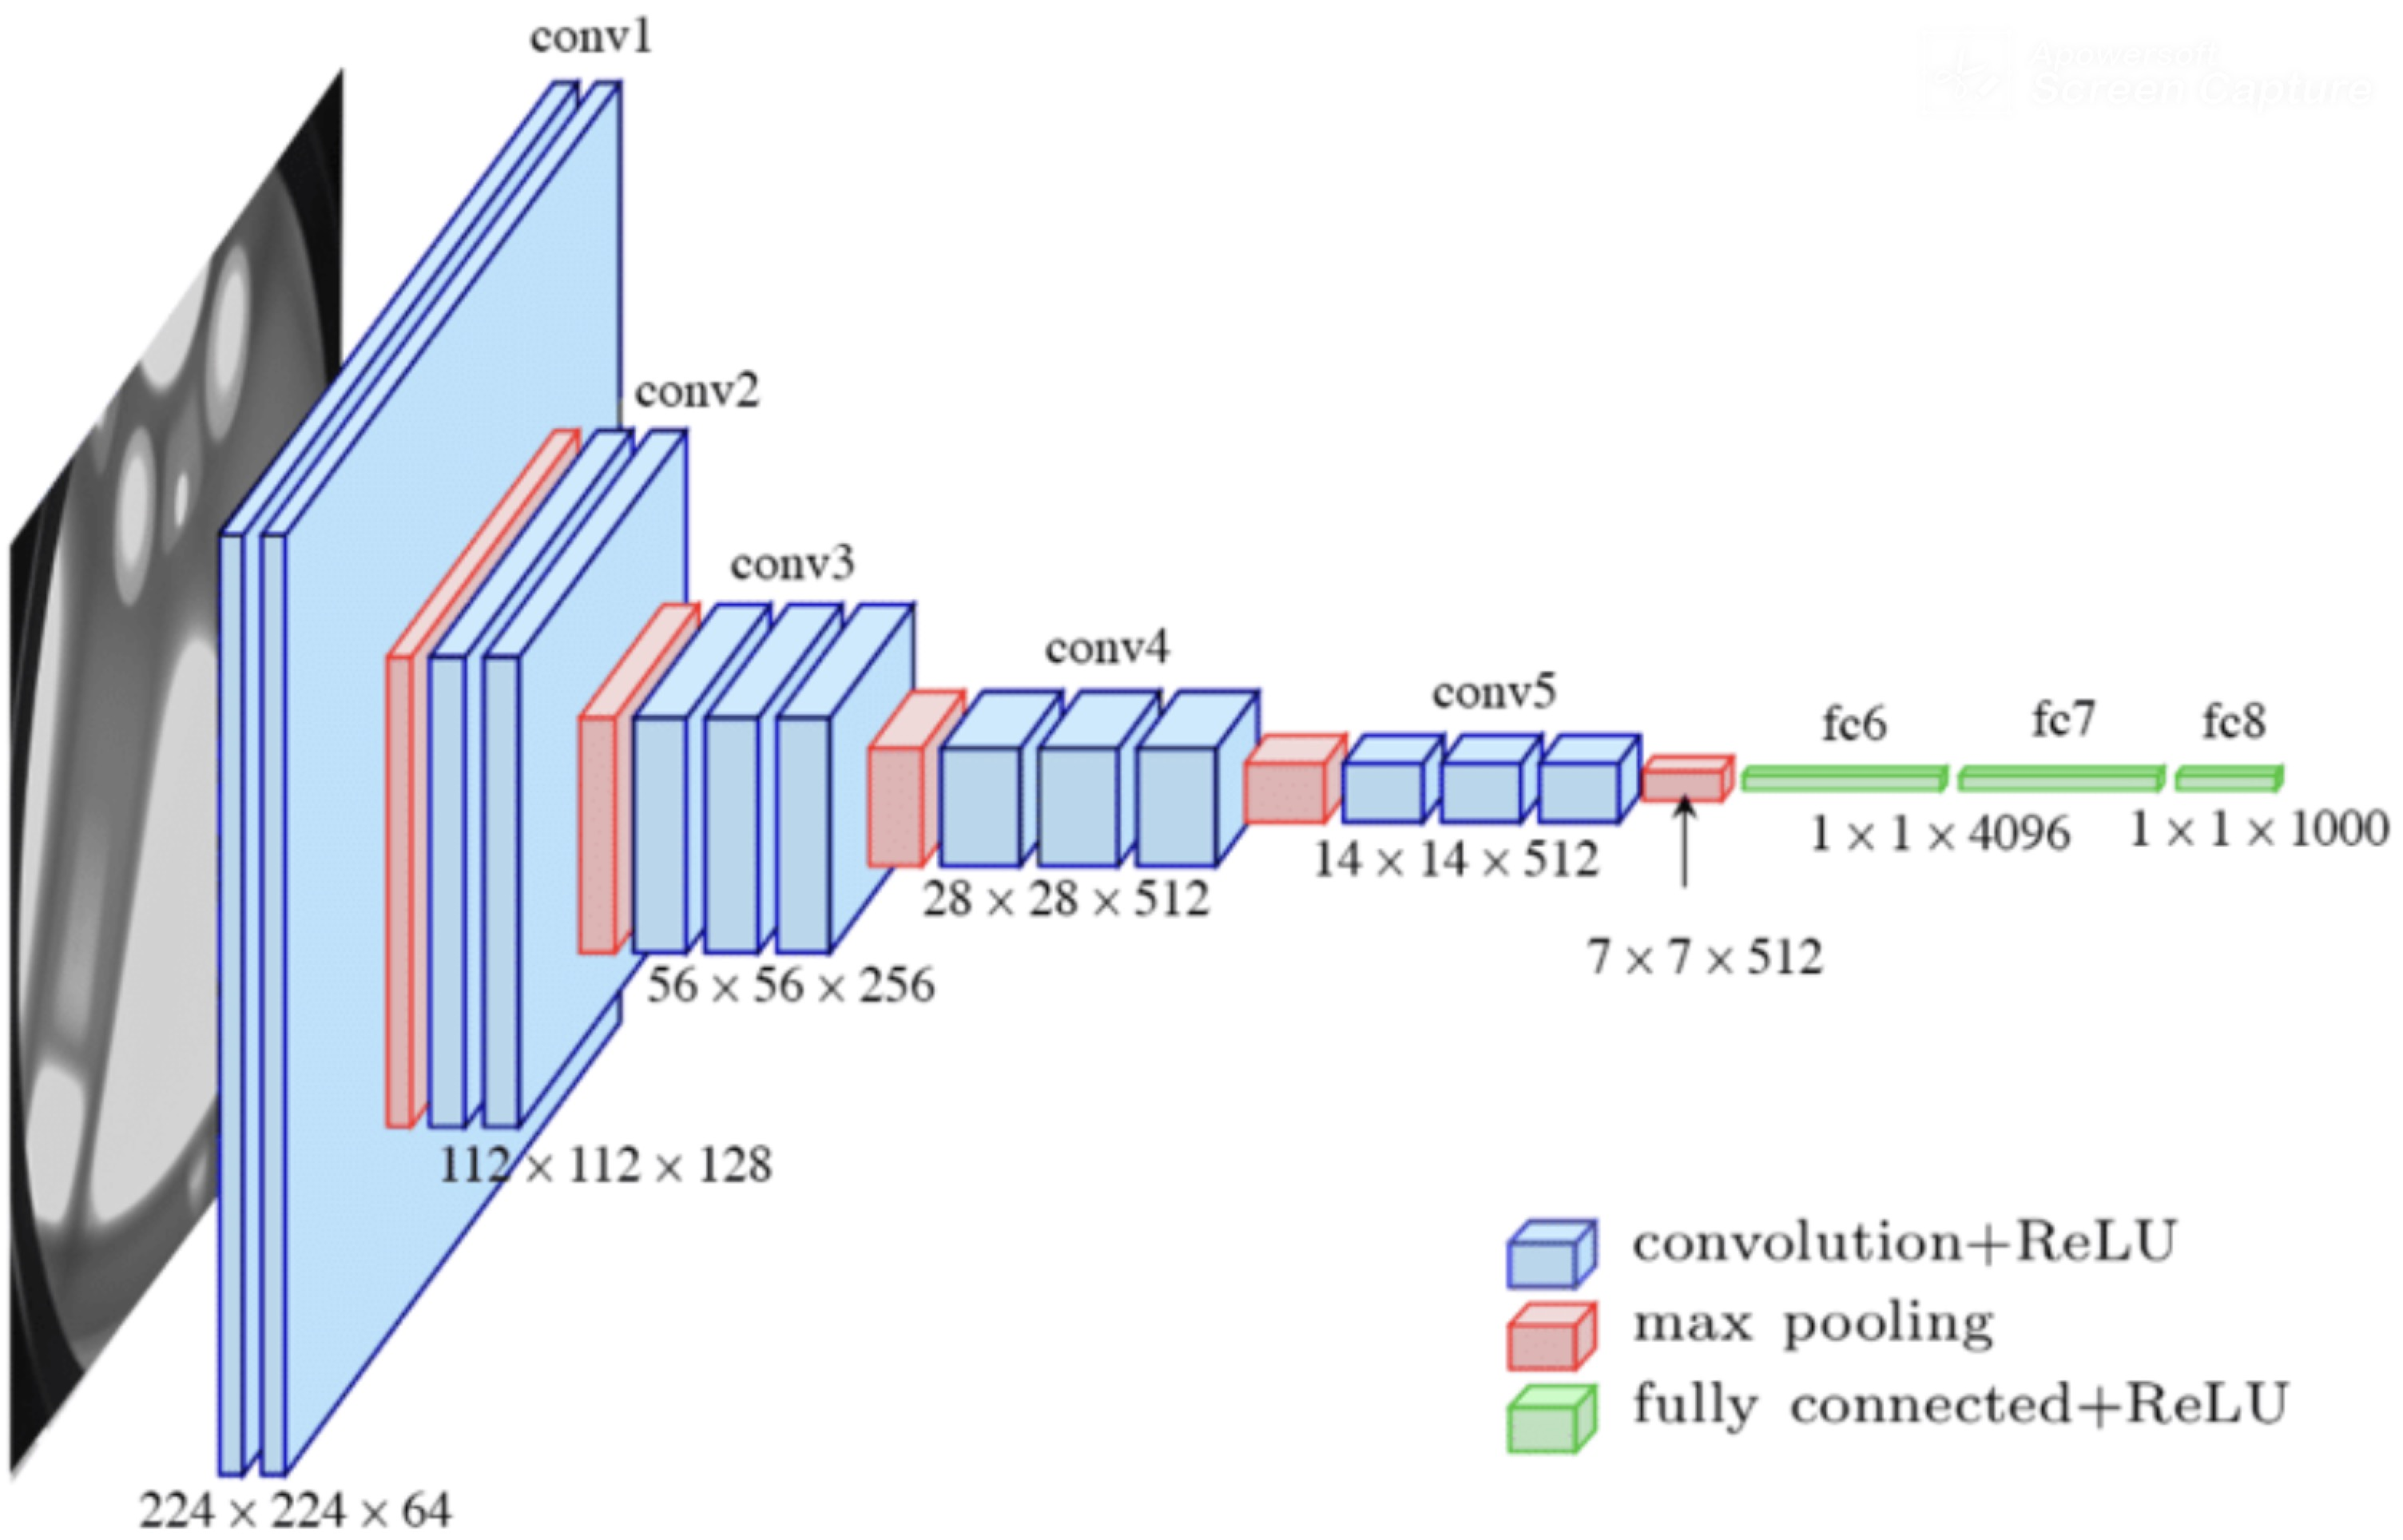

VGG16 is composed of 13 convolutional layers, 5 max-pooling layers, and 3 fully connected layers. Therefore, the number of layers having tunable parameters is 16 (13 convolutional layers and 3 fully connected layers). That is the reason why the model name is VGG16. The number of filters in the first block is 64, then this number is doubled in the later blocks until it reaches 512. This model is finished by two fully connected hidden layers and one output layer. The two fully connected layers have the same neuron numbers which are 4096. The output layer consists of 1000 neurons corresponding to the number of categories of the Imagenet dataset. In the next section, we are going to implement this architecture on Keras.

## 2. Implementation of VGG16 on Keras
Firstly, we need to import some necessary libraries:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# import metric
from keras.metrics import categorical_crossentropy
# optimization method 
from keras.optimizers import SGD

import numpy as np
import pandas as pd 

Once all necessary libraries are ready, the model can be implemented by the following function:

In [ ]:
def VGG16():
  # Initialize the model
  model = Sequential()

  # layer 1-2: 2 convolutional layers + 1 max-pooling layer 
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = (224,224,3)))
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

  # number of filters and convolutions in each layer:
  filters_convs = [(128, 2), (256, 3), (512, 3), (512,3)]
  
  for n_filters, n_convs in filters_convs:
    for _ in np.arange(n_convs):
      model.add(Conv2D(filters = n_filters, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    # max-pooling layer 
    model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1000,activation = 'softmax'))

  # compile the model with a loss function, a metric and an optimization method
  opt = SGD(lr = 0.005) # stochastic gradient descent method with learning rate lr = 0.1
  model.compile(loss = categorical_crossentropy, 
                optimizer = opt, 
                metrics = ['accuracy'])
  return model

Now, let’s see the detailed information in each layer of the model:

In [ ]:
vgg16_model = VGG16()
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

As the number of filters increases following the model depth, hence the number of parameters increases significantly in the later layers. Especially, the parameter number in the two fully connected hidden layers is very large, with 102, 764, 544, and 16, 781, 312 parameters, respectively. It accounts for 86.4% parameters of the whole model.

A large number of parameters may reduce the model performance. Sometimes, it leads to overfitting. A natural question arises: Is it possible to replace the fully connected layers with something to reduce the model complexity? The NiN model, which we are going to discuss in the next section, is an appropriate answer to this question.

# II. Network in Network (NiN)
## 1. Introduction
Network in Network (NiN) is a deep convolutional neural network introduced by Min Lin, Qiang Chen, Shuicheng Fan [2]. The structure of this network is different from the classic CNN models:
- The classic models use linear convolutional layers and the layers are followed by an activation function to scan the input, while the NiN uses multilayer perceptron convolutional layers, at which each layer includes a micro-network.


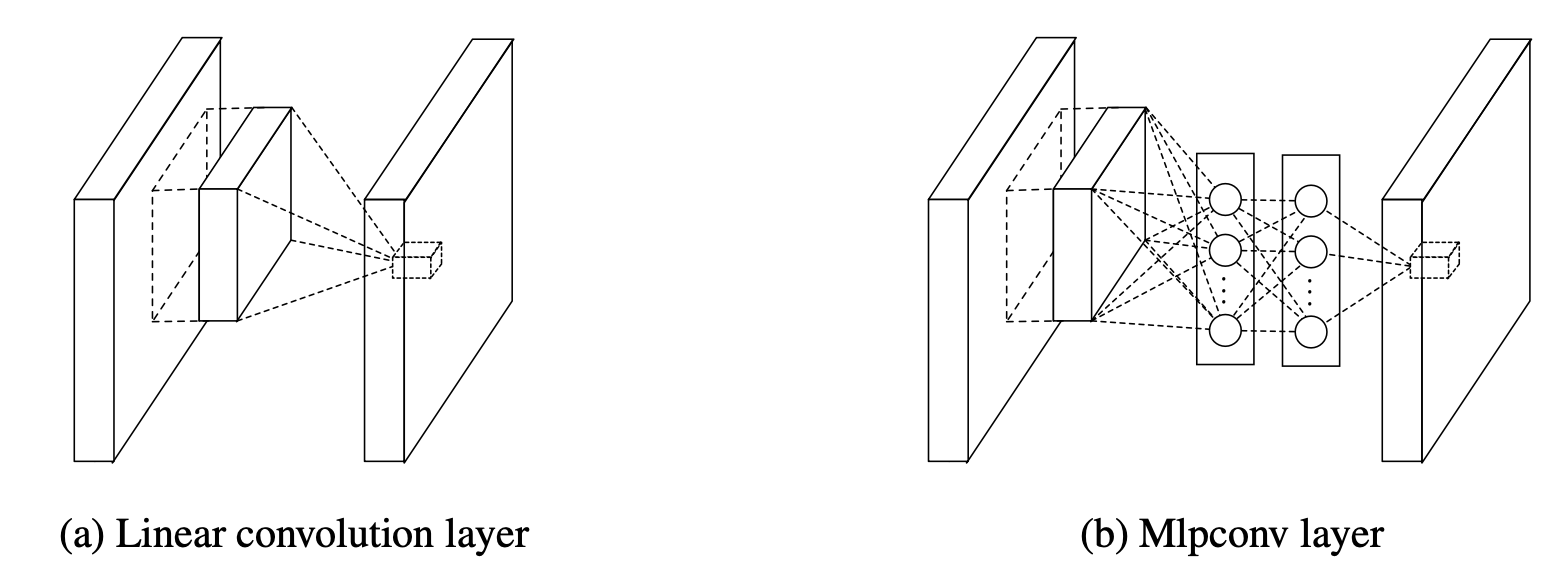

- The classic models apply fully connected layers at the end of the model to classify objects, while the NiN uses a global average pooling layer before feeding the output to the softmax layer. The global average pooling layer has some advantages compared to the traditional fully connected layers. Firstly, it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Secondly, there is no parameter to optimize in the global average pooling layer, so it helps to avoid the overfitting phenomena. Finally, using the global average pooling layer is more robust to spatial translations of the input, because it sums out the spatial information.

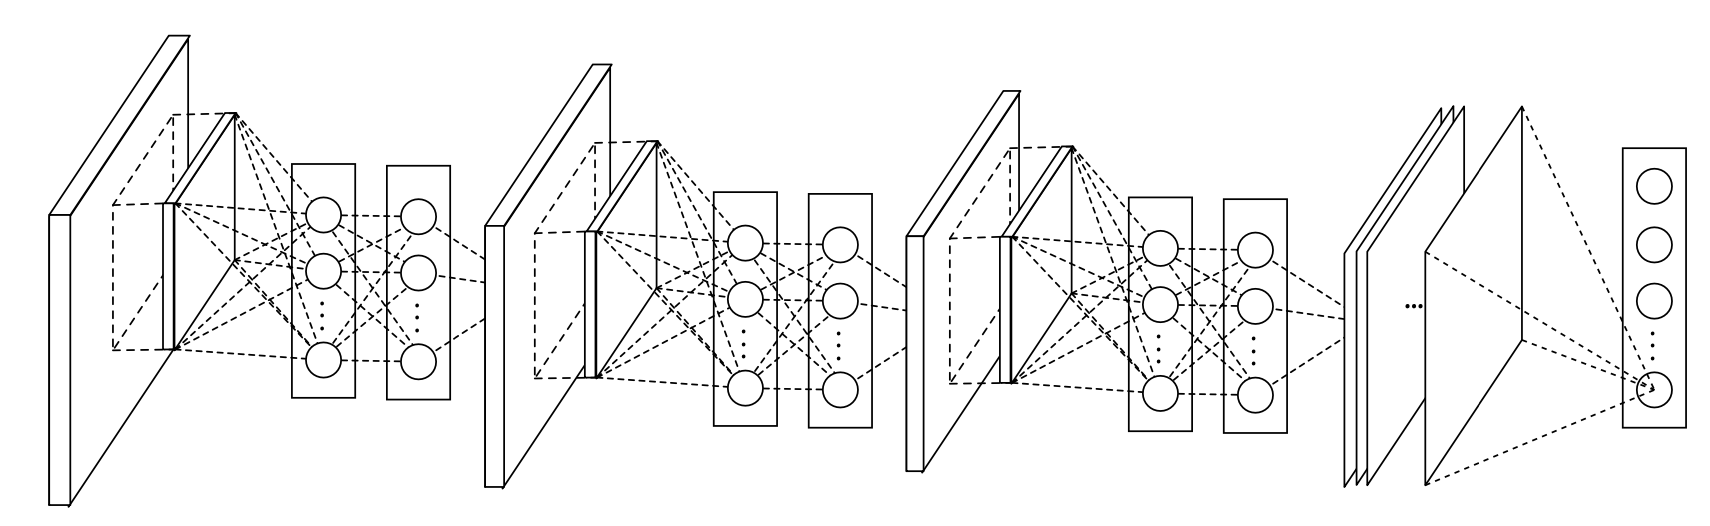

## 2. Implementation of NiN on Keras 
The original NiN network is composed of four NiN blocks. Each block includes three convolutional layers:
- The first layer uses a filter window whose shape belongs to {11 × 11, 5 × 5, 3 × 3}.
- The last two layers are 1 × 1 convolutional layers.

Each NiN block is followed by a Max-pooling layer with pooling size 3 × 3, and strides of 2. Except the last block is followed by a Global Average Pooling layer.

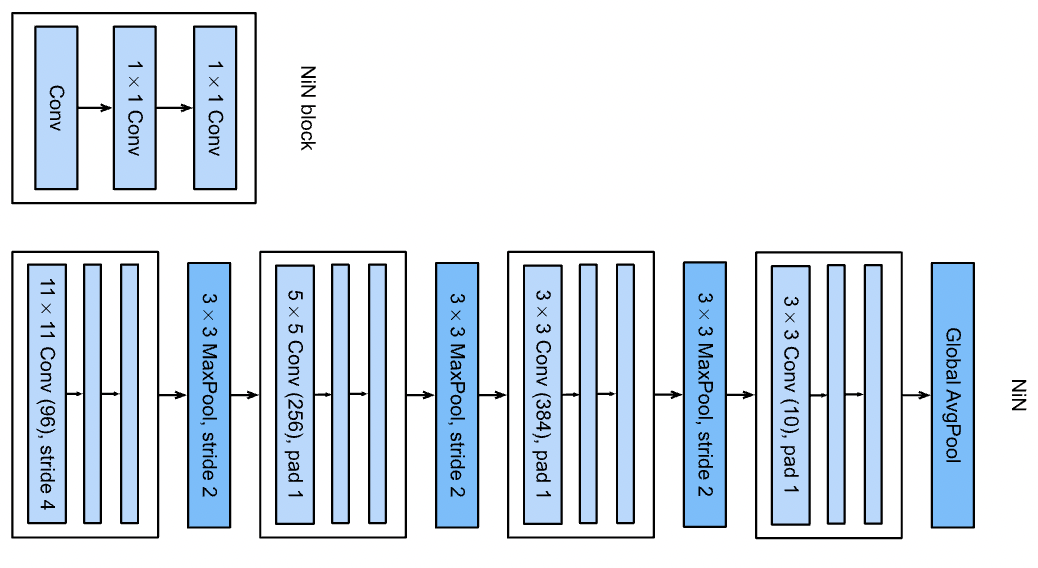

This model is implemented easily by the following function:

In [ ]:
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# import metric
from keras.metrics import categorical_crossentropy
# optimization method 
from keras.optimizers import SGD

import numpy as np
import pandas as pd 

In [ ]:
def NiN():
  # Initialize the model
  model = Sequential()

  # block 1: 
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = 4, activation = 'relu', input_shape = (224, 224,3)))
  model.add(Conv2D(filters = 96, kernel_size = (1,1), activation = 'relu'))
  model.add(Conv2D(filters = 96, kernel_size = (1,1),  activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # blocks 2-3: 
  # paras includes a sequence of parmaters (filters, kernel_size) 
  paras = [(256, (5,5)), (384, (3,3))]
  for n_filters, kernel_size in paras: 
    model.add(Conv2D(filters = n_filters, kernel_size = kernel_size, padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = n_filters, kernel_size = (1,1), activation = 'relu'))
    model.add(Conv2D(filters = n_filters, kernel_size = (1,1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (3,3), strides = 2))
  
  model.add(Dropout(0.5))
  # block 4:
  model.add(Conv2D(filters = 10, kernel_size = (3,3), padding = 'valid', activation = 'relu'))
  model.add(Conv2D(filters = 10, kernel_size = (1,1), activation = 'relu'))
  model.add(Conv2D(filters = 10, kernel_size = (1,1), activation = 'relu'))

  # Global Average pooling layer 
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1000, activation = 'softmax'))

  # compile the model
  opt = SGD(lr = 0.005)
  model.compile(loss = categorical_crossentropy,
                optimizer = opt, 
                metrics = ['accuracy'])
  
  return model

Let’s consider the detailed information (i.e the output size and parameter number) for each layer of the model:

In [ ]:
NiN_model = NiN()
NiN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 54, 54, 96)        9312      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 54, 54, 96)        9312      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 22, 256)       614656    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 256)       65792     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 22, 22, 256)      

Remark that the global average pooling layer has no parameter. Hence using this layer instead of fully connected layers helps to reduce significantly the model complexity. The parameter number of this model is much smaller compared to the one of the VGG model.

# III. Conclusion 
We have discovered the architectures of VGG and NiN models. The construction of the VGG model is similar to the previous models, LeNet and Alexnet. They are all composed of convolutional layers, pooling layers, and terminated by fully connected layers. The reasonable depth extension of VGG makes it outperform the previous ones. However, the number of parameters in fully connected layers is too large, especially in cased of large-scale image processing. NiN overcomes this drawback by replacing these layers with a global average pooling layer. This layer has some advantages, it is more native to enforce the correspondences between feature maps and categories. Besides, there is no parameter to optimize in this layer. Hence, using this layer helps to avoid overfitting while training the model. The appearance of the NiN model is also an inspiration for the construction of later modern CNN models that we are going to discuss in the next posts.
I hope that this post is helpful for you! Don’t hesitate to follow my medium blog to receive related topics.

**References:**

[1] Simonyan, Karen, and Andrew Zisserman. “Very deep convolutional networks for large-scale image recognition.” arXiv preprint arXiv:1409.1556 (2014).

[2] Lin, Min, Qiang Chen, and Shuicheng Yan. “Network in network.” arXiv preprint arXiv:1312.4400 (2013).